In [1]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
##

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
import os
os.chdir(r'/usr/slurm/venkatesh/HBN/')
subjs = sorted(os.listdir())[1:-2]
#cd


In [4]:
cd

/homes/v20subra


# Importing the data

In [ ]:
def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
    ch_names = list(chans.values[1:,0])
#print(type(ch_names))
    #ch_names_appended = list(np.append(ch_names,'stim_channel'))
    #print(len(data[0]))
    types = ['eeg']*(len(ch_names))
    #types.append('stim')
    #data2 = np.zeros([1,len(data[0])]) #len(raw.times)
    #data_appended = np.append(data,data2,axis = 0)

    #print(np.shape(data_appended))
#print(len(types))

#types
    info = mne.create_info(ch_names,sfreq = fs,ch_types = types)
#raw=mne.io.RawArray(data, info)

#mne.find_events(raw,stim_channel='stim')
    raw = mne.io.RawArray(data, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)

    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
        
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']
        
         
        if filename == 'NDARDX770PJK':
           
            values.extend(["break cnt"])
            
            idx = [i for i, e in enumerate(values) if e == 'break cnt']
        
        samples = raw_events[1][1:idx[0]].to_numpy(dtype = int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][1:idx[0]].to_numpy(dtype = int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    return raw



def preparation(filename):
    path_to_file = '/usr/slurm/venkatesh/HBN/%s/EEG/preprocessed/csv_format/Video3_data.csv'% filename
    path_to_events = '/usr/slurm/venkatesh/HBN/%s/EEG/preprocessed/csv_format/Video3_event.csv' %filename
    path_to_montage_glob = '/S4B2/GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '/usr/slurm/venkatesh/HBN/%s/EEG/preprocessed/csv_format/Video3_chanlocs.csv' %filename
    fs = 500
    chans_glob = mne.channels.read_custom_montage(fname = 'S4B2/GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated
# channels to exclude because noisy (Nentwich paper)


    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events


sub1_raw,sub1_events = preparation(subjs[0])
sub2_raw,sub2_events = preparation(subjs[1])
sub3_raw,sub3_events = preparation(subjs[2])
sub4_raw,sub4_events = preparation(subjs[3])
sub5_raw,sub5_events = preparation(subjs[4])
sub6_raw,sub6_events = preparation(subjs[5])
sub7_raw,sub7_events = preparation(subjs[6])
sub8_raw,sub8_events = preparation(subjs[7])
sub9_raw,sub9_events = preparation(subjs[8])
sub10_raw,sub10_events = preparation(subjs[9])

# Picking Event of interest

In [6]:
def epochs(subject_raw,subject_events):

    epochs = mne.Epochs(subject_raw, subject_events, [83,103,9999], tmin=0, tmax=170,preload=True,baseline=(0,None))
    epochs_resampled = epochs#.resample(250) # Downsampling to 250Hz
    
    return epochs_resampled['83']



# CCA

In [7]:
import numpy as np
from scipy.linalg import eigh
from timeit import default_timer


def train_cca(data):
    """Run Correlated Component Analysis on your training data.
        Parameters:
        ----------
        data : dict
            Dictionary with keys are names of conditions and values are numpy
            arrays structured like (subjects, channels, samples).
            The number of channels must be the same between all conditions!
        Returns:
        -------
        W : np.array
            Columns are spatial filters. They are sorted in descending order, it means that first column-vector maximize
            correlation the most.
        ISC : np.array
            Inter-subject correlation sorted in descending order
    """

    start = default_timer()

    C = len(data.keys())
    print(f'train_cca - calculations started. There are {C} conditions')

    gamma = 0.1
    Rw, Rb = 0, 0
    for cond in data.values():
        N, D, T, = cond.shape
        print(f'Condition has {N} subjects, {D} sensors and {T} samples')
        cond = cond.reshape(D * N, T)

        # Rij
        Rij = np.swapaxes(np.reshape(np.cov(cond), (N, D, N, D)), 1, 2)
        
        # Rw
        Rw = Rw + np.mean([Rij[i, i, :, :]
                           for i in range(0, N)], axis=0)
        
        # Rb
        Rb = Rb + np.mean([Rij[i, j, :, :]
                           for i in range(0, N)
                           for j in range(0, N) if i != j], axis=0)
        covariance = np.cov(cond)
    # Divide by number of condition
    Rw, Rb = Rw/C, Rb/C

    # Regularization
    Rw_reg = (1 - gamma) * Rw + gamma * np.mean(eigh(Rw)[0]) * np.identity(Rw.shape[0])

    # ISCs and Ws
    [ISC, W] = eigh(Rb, Rw_reg) #Eigen values, W matrix
    
    # Make descending order
    ISC, W = ISC[::-1], W[:, ::-1] 
    #print(ISC[0])
    stop = default_timer()

    print(f'Elapsed time: {round(stop - start)} seconds.')
    return W, ISC


def apply_cca(X, W, fs):
    """Applying precomputed spatial filters to your data.
        Parameters:
        ----------
        X : ndarray
            3-D numpy array structured like (subject, channel, sample)
        W : ndarray
            Spatial filters.
        fs : int
            Frequency sampling.
        Returns:
        -------
        ISC : ndarray
            Inter-subject correlations values are sorted in descending order.
        ISC_persecond : ndarray
            Inter-subject correlations values per second where first row is the most correlated.
        ISC_bysubject : ndarray
            Description goes here.
        A : ndarray
            Scalp projections of ISC.
    """

    start = default_timer()
    print('apply_cca - calculations started')

    N, D, T = X.shape
    # gamma = 0.1
    window_sec = 5
    X = X.reshape(D * N, T)
    
    # Rij
    Rij = np.swapaxes(np.reshape(np.cov(X), (N, D, N, D)), 1, 2)
    print(Rij.shape)
    # Rw
    Rw = np.mean([Rij[i, i, :, :]
                  for i in range(0, N)], axis=0)
    # Rw_reg = (1 - gamma) * Rw + gamma * np.mean(eigh(Rw)[0]) * np.identity(Rw.shape[0])

    # Rb
    Rb = np.mean([Rij[i, j, :, :]
                  for i in range(0, N)
                  for j in range(0, N) if i != j], axis=0)

    # ISCs
    ISC = np.sort(np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W))[::-1]

    # Scalp projections
    A = np.linalg.solve(Rw @ W, np.transpose(W) @ Rw @ W)  # a, b. 
    
    # ISC by subject
    print('by subject is calculating')
    ISC_bysubject = np.empty((D, N))

    for subj_k in range(0, N):
        Rw, Rb = 0, 0
        Rw = np.mean([Rw + 1 / (N - 1) * (Rij[subj_k, subj_k, :, :] + Rij[subj_l, subj_l, :, :])
                      for subj_l in range(0, N) if subj_k != subj_l], axis=0)
        Rb = np.mean([Rb + 1 / (N - 1) * (Rij[subj_k, subj_l, :, :] + Rij[subj_l, subj_k, :, :])
                      for subj_l in range(0, N) if subj_k != subj_l], axis=0)

        ISC_bysubject[:, subj_k] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)

    # ISC per second
    print('by persecond is calculating')
    ISC_persecond = np.empty((D, int(T / fs) ))
    window_i = 0

    for t in range(0, T, fs):

        Xt = X[:, t:t+window_sec*fs] #[subj 1, subj 2........subj 10]
       
        # the covariance
        Rij = np.cov(Xt) #910, 910for all the subjects 
        # <----10 subjects---->
        #  [sub1, sub2... sub10 ] sub 1
        #  [sub1, sub2... sub10 ] sub 2
        #  [sub1, sub2... sub10 ] ..
        #  [sub1, sub2... sub10 ] ..
        #   [sub1, sub2... sub10 ] sub 10
        
        
        
        Rw = np.mean([Rij[i:i + D, i:i + D] # Correlation diagonally (itself)
                      for i in range(0, D * N, D)], axis=0) 
        
        Rb = np.mean([Rij[i:i + D, j:j + D]
                      for i in range(0, D * N, D)
                      for j in range(0, D * N, D) if i != j], axis=0) #Correlation with other subjects
        
        ISC_persecond[:, window_i] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)
        window_i += 1
        
    stop = default_timer()
    print(f'Elapsed time: {round(stop - start)} seconds.')

    return ISC, ISC_persecond, ISC_bysubject, A

# Preparation to perform CCA

In [8]:
dic = dict()

dic['condition1'] = np.append(sub1_raw.get_data()[:91,516:85516].reshape(1,91,85000),sub2_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)

#for i in range(2,10):
#    dic['condition1'] = np.append(dic['condition1'],sub[i].get_data()[:,:86030].reshape(1,92,86030) ,axis=0)

dic['condition1'] = np.append(dic['condition1'],sub3_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub4_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub5_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub6_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub7_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub8_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub9_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub10_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)    

In [9]:
[W,ISC] = train_cca(dic)
#np.shape( sub1_raw.get_data() )

isc_results = dict()
for cond_key, cond_values in dic.items():
    isc_results[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], apply_cca(cond_values, W, 500)))


train_cca - calculations started. There are 1 conditions
Condition has 10 subjects, 91 sensors and 85000 samples
Elapsed time: 3 seconds.
apply_cca - calculations started
(10, 10, 91, 91)
by subject is calculating
by persecond is calculating
Elapsed time: 7 seconds.


In [10]:
vals = np.reshape( ((np.random.rand(100,10) * np.random.rand(100,10)).T), [10,1,100])


#print(f'Elapsed time: {round(stop - start)} seconds.')


# Intra-subject Study Results

Text(0.5, 1.0, 'ISC')

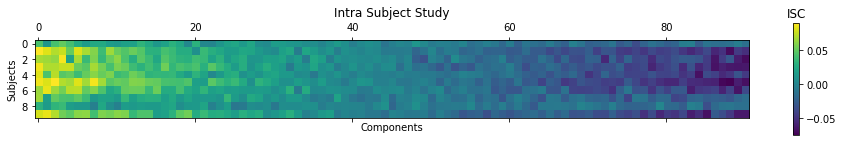

In [11]:
plt.matshow( (isc_results['condition1']['ISC_bysubject']).T)
plt.title('Intra Subject Study')
plt.ylabel('Subjects')
plt.xlabel('Components')

cb =plt.colorbar()
cb.ax.set_title('ISC')

# ISC results

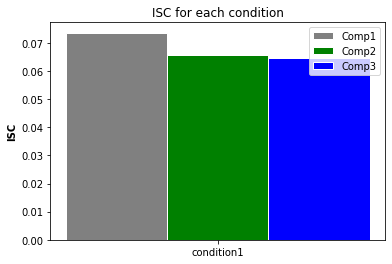

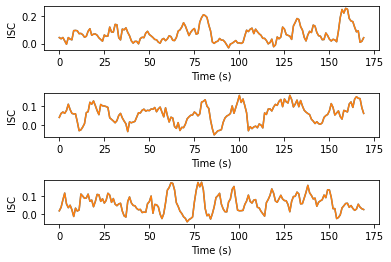

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def plot_isc(isc_all):
    # plot ISC as a bar chart
    plt.figure()
    comp1 = [cond['ISC'][0] for cond in isc_all.values()]
    comp2 = [cond['ISC'][1] for cond in isc_all.values()]
    comp3 = [cond['ISC'][2] for cond in isc_all.values()]
    barWidth = 0.2
    r1 = np.arange(len(comp1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, comp1, color='gray', width=barWidth, edgecolor='white', label='Comp1')
    plt.bar(r2, comp2, color='green', width=barWidth, edgecolor='white', label='Comp2')
    plt.bar(r3, comp3, color='blue', width=barWidth, edgecolor='white', label='Comp3')
    plt.xticks([r + barWidth for r in range(len(comp1))], isc_all.keys())
    plt.ylabel('ISC', fontweight='bold')
    plt.title('ISC for each condition')
    plt.legend()
    plt.show()

    # plot ISC_persecond
    for cond in isc_all.values():
        for comp_i in range(0, 3):
            plt.subplot(3, 1, comp_i+1)
            plt.plot(cond['ISC_persecond'][comp_i])
            #plt.plot ((np.array(vals)[:,comp_i,:]).T)
            #peaks = scipy.signal.find_peaks(isc_results['condition1']['ISC_persecond'][comp_i],distance=15)
            plt.subplots_adjust(hspace=1)

            plt.plot(isc_results['condition1']['ISC_persecond'][comp_i])
            #plt.plot(peaks[0],isc_results['condition1']['ISC_persecond'][comp_i][peaks[0]],marker='o', ls="")

            
            plt.xlabel('Time (s)')
            plt.ylabel('ISC')
            

            #plt.title('ISC per second for each condition')


    
plot_isc(isc_results)


# Noise Floor

In [8]:
#a = list(range(100))
import random

from tqdm.notebook import tqdm

def shuffle(a):
    
    for i in (range(10)):
        for j in range(91):
            np.random.seed(i)
            
            chunked = chunks(a['condition1'][i][j][:85000])
            np.random.shuffle(chunked[0])
            chunked = np.reshape(chunked,[85000,])
            
    return a

def chunks(chunk):
    chunked = chunk[:85000]
    chunked= chunked.reshape(1,34,2500)
    return chunked

valstest = []
for i in tqdm(range(1000)):
    shuffled = shuffle(dic)
    isc_resultstest_ = dict()
    print('step {}'.format(i))
    for cond_key, cond_values in shuffled.items():
        isc_resultstest_[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], apply_cca(cond_values, W, 500)))
        #print(np.mean(isc_results['condition1']['ISC_persecond'][0]))
        valstest.append(isc_resultstest_['condition1']['ISC_persecond'])
        #print(np.shape(isc_resultstest_['condition1']['ISC_persecond']))
#np.append(sub1_raw.get_data()[:91,516:85779].reshape(1,91,85263),sub2_raw.get_data()[:91,516:85779].reshape(1,91,85263) ,axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'dic' is not defined

In [7]:
len(valstest)

NameError: name 'valstest' is not defined

## Results

In [91]:
import seaborn as sns
sns.set_theme()

significance = np.where(np.max(np.array(valstest)[:,0,:],axis=0)<isc_results['condition1']['ISC_persecond'][0])


plt.plot(isc_results['condition1']['ISC_persecond'][0])
plt.plot (np.max(np.array(valstest)[:,0,:],axis=0).T,color='grey')
plt.plot(np.reshape(significance,(21,)),isc_results['condition1']['ISC_persecond'][0][significance],marker='o', ls="",color='red')
#duration = (np.sum(isc_results['condition1']['ISC_persecond'][0]>np.max(vals,axis=0)[0])/170)
#plt.title('First Component, %.2f perc of duration above the significance' %(duration*100))
plt.title('First component with 5-seconds block')
plt.xlabel('time (s)')
plt.ylabel('ISC')


NameError: name 'valstest' is not defined

# Source Inversion

## Source Inversion on ISC

In [11]:
#mne.viz.plot_topomap(isc_results['condition1']['A'][2,:],pos=sub1_raw.info,vmin=-0.8472,vmax=0.21,ch_type='eeg',cmap='inferno')
(isc_results['condition1']['ISC_persecond'][0])[102]

0.008659540069938524

In [12]:
epochs_ISC = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][:],[1,91,91]),mne.create_info(sub1_raw.info['ch_names'],sfreq=1,ch_types = 'eeg'))
#np.shape(isc_results['condition1']['A'][:])

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [13]:
cov_isc =mne.compute_covariance(epochs_ISC)

Computing rank from data with rank=None


<ipython-input-13-d680cd4d598b>:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_isc =mne.compute_covariance(epochs_ISC)
<ipython-input-13-d680cd4d598b>:1: RuntimeWarning: Too few samples (required : 460 got : 91), covariance estimate may be unreliable
  cov_isc =mne.compute_covariance(epochs_ISC)


    Using tolerance 4.6e-06 (2.2e-16 eps * 91 dim * 2.3e+08  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
Reducing data rank from 91 -> 91
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 91
[done]


In [14]:
from mne.datasets import fetch_fsaverage

import os.path as op
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


In [15]:
fwd_model_isc = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)

Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  91 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BE

In [16]:
from mne.minimum_norm import make_inverse_operator, apply_inverse, apply_inverse_epochs

inverse_operator_isc = make_inverse_operator(sub1_raw.info, fwd_model_isc, cov_isc)



Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 91 dim * 5.7e+12  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-16-130cdc2383ee>:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator_isc = make_inverse_operator(sub1_raw.info, fwd_model_isc, cov_isc)
<ipython-input-16-130cdc2383ee>:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator_isc = make_inverse_operator(sub1_raw.info, fwd_model_isc, cov_isc)


    largest singular value = 9.53834
    scaling factor to adjust the trace = 8.79532e+16 (nchan = 91 nzero = 0)


In [17]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2


epochs_ISC_2 = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][0],[1,91,1]),mne.create_info(sub1_raw.info['ch_names'],sfreq=1,ch_types = 'eeg'))

# epochs['30'].average() = Averaged evoked response for the event 30
stc_isc = apply_inverse_epochs(epochs_ISC_2, inverse_operator_isc, lambda2,
                             method=method, pick_ori=None, verbose=True)
stc_isc

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 5 (1.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]


[<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 0.0 (ms), tstep : 1000.0 (ms), data shape : (20484, 1), ~320 kB>]

In [ ]:
stc_isc

(array([  5.,   9.,  15.,  27.,  26.,  90., 114., 187., 297., 408., 418.,
        378., 330., 291., 272., 266., 234., 247., 214., 245., 226., 182.,
        201., 174., 143., 183., 162., 164., 174., 171., 188., 174., 171.,
        172., 176., 162., 161., 175., 178., 189., 169., 171., 171., 183.,
        187., 162., 186., 183., 175., 173., 184., 182., 180., 193., 228.,
        201., 203., 213., 221., 207., 184., 207., 214., 210., 235., 237.,
        235., 223., 240., 249., 259., 267., 296., 304., 292., 307., 342.,
        319., 356., 349., 346., 393., 350., 349., 355., 324., 336., 333.,
        278., 212., 220., 140.,  73.,  29.,  19.,   8.,  15.,   5.,   2.,
          1.]),
 array([-1.00000000e+00, -9.80000000e-01, -9.60000000e-01, -9.40000000e-01,
        -9.20000000e-01, -9.00000000e-01, -8.80000000e-01, -8.60000000e-01,
        -8.40000000e-01, -8.20000000e-01, -8.00000000e-01, -7.80000000e-01,
        -7.60000000e-01, -7.40000000e-01, -7.20000000e-01, -7.00000000e-01,
        -6.800

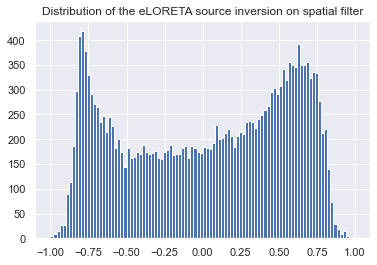

In [105]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(stc_isc[0].data)

plt.title('Distribution of the eLORETA source inversion on spatial filter')
scaled = scaler.transform(stc_isc[0].data)
plt.hist(scaled,bins=100)

In [111]:
index = np.where( np.logical_or(scaled<-0.5, scaled>0.5))[0]
scaled[list(set(list(range(20484)))-set(index))] =0


In [1]:
import brainspace.mesh

mesh = brainspace.mesh.mesh_io.read_surface('S4B2/brainnotation/tpl-fsaverage_den-10k_hemi-L_pial.surf.gii')
mesh2 = brainspace.mesh.mesh_io.read_surface('S4B2/brainnotation/tpl-fsaverage_den-10k_hemi-R_pial.surf.gii')


from surfplot import Plot
%matplotlib qt
%gui qt

p = Plot(mesh,mesh2, zoom=1.2, views='lateral')

p.add_layer(scaled, color_range=None,cmap = 'seismic')
fig = p.build()
plt.title('1st spatial filter using eLORETA (after the threshold on range)')
fig.show()


NameError: name 'reload' is not defined

In [24]:
#src = mne.setup_source_space('fsaverage', spacing='oct6',
#                             add_dist=False, subjects_dir=subjects_dir)#write_source_spaces('fsaverage-new-ico5-src.fif', src)
#mne.write_source_spaces('fsaverage-new-oct6-src.fif', src)



SyntaxError: invalid syntax (<ipython-input-24-e623cb8e08ab>, line 3)

In [37]:
stc_isc[0].data.min()


3.1737942383757724e-08

In [111]:
vertno_max, time_max = stc_isc[0].get_peak()
%matplotlib qt
%gui qt 
from pyvistaqt import BackgroundPlotter
fig, ax = plt.subplots()
ax.plot(1e3 * stc_isc[0].times, stc_isc[0].data.T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)
brain = stc_isc[0].plot(subjects_dir=subjects_dir, initial_time=time_max,time_viewer=False,backend='pyvista')
#surfer_kwargs = dict(
 #   hemi='both', subjects_dir=subjects_dir,
  #  clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
   # initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
#brain = stc.plot(**surfer_kwargs)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',scale_factor=0.6, alpha=0.5)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='red',scale_factor=0.6, alpha=0.5)

brain.add_text(0.1, 0.9, 'eLORETA for the first component', 'title' ,font_size=14)



Using pyvista 3d backend.

Using control points [8.08546892e-08 8.16022916e-08 8.54160340e-08]
Using notebook 3d backend.



QtDeprecationError: `BackgroundPlotter` has moved to pyvistaqt.
    You can install this from PyPI with: `pip install pyvistaqt`
    Then import it via: `from pyvistaqt import BackgroundPlotter`
    `BackgroundPlotter` is no longer accessible by `pyvista.BackgroundPlotter`
    See https://github.com/pyvista/pyvistaqt


# Source Estimation on ISC with time-series

## Picking necessary chunks of time-series data

In [11]:
#[29,33],[67,71],[77,83],[130,135],[155,164]]]

#np.max(valstest,axis=0)

#significance
indexes = np.hstack([np.arange(159*500-1000,159*500+1060)])#,np.arange(67*500,72*500),np.arange(77*500,84*500),np.arange(130*500,136*500),np.arange(155*500,165*500)])
indexes2 = np.hstack([np.arange(100*500-1000,100*500+1060)])
#np.where(isc_results['condition1']['ISC_persecond'][0] == isc_results['condition1']['ISC_persecond'][0].max())

In [12]:
#isc_results['condition1']['A'][0]
#sub1_trial = isc_results['condition1']['A'][0] @ sub1_raw.get_data()
import tqdm
#sub1_trial = np.zeros([91,85001])
#a = [sub1_trial[:,i] (sub1_raw.get_data()[:,i]*isc_results['condition1']['A'][0]) for i in tqdm.tqdm(range(86040))]
 #sub1_trial[:,i] = (sub1_raw.get_data()[:,i]*isc_results['condition1']['A'][0])   

def element_wise_multi(epochs):
    subjects = isc_results['condition1']['A'][0].T @ epochs
    return subjects

def spatial_filter(epochs):
    subjects = np.multiply(epochs.T,isc_results['condition1']['A'][0])
    print(np.shape(subjects))
    subjects_final = np.reshape(subjects,[1,91,2060])
    return subjects_final
#np.shape(element_wise_multi(epochs1_ISC_ts.get_data()[:,:,indexes]))

#np.shape(isc_results['condition1']['A'][0],sub1_raw.get_data())

In [13]:
np.shape( spatial_filter(np.reshape( epochs1_ISC_ts.get_data()[:,:,indexes], [91,2060])) )

NameError: name 'epochs1_ISC_ts' is not defined

In [14]:
epochs1_ISC_ts = epochs(sub1_raw,sub1_events)
epochs2_ISC_ts = epochs(sub2_raw,sub2_events)
epochs3_ISC_ts = epochs(sub3_raw,sub3_events)
epochs4_ISC_ts = epochs(sub4_raw,sub4_events)
epochs5_ISC_ts = epochs(sub5_raw,sub5_events)
epochs6_ISC_ts = epochs(sub6_raw,sub6_events)
epochs7_ISC_ts = epochs(sub7_raw,sub7_events)
epochs8_ISC_ts = epochs(sub8_raw,sub8_events)
epochs9_ISC_ts = epochs(sub9_raw,sub9_events)
epochs10_ISC_ts = epochs(sub10_raw,sub10_events)


Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 eve

In [24]:
epochs_averaged_ISC_ts = np.average(epochs1_ISC_ts.get_data()[:,:,indexes]+
epochs2_ISC_ts.get_data()[:,:,indexes]+
epochs3_ISC_ts.get_data()[:,:,indexes]+
epochs4_ISC_ts.get_data()[:,:,indexes]+
epochs5_ISC_ts.get_data()[:,:,indexes]+
epochs6_ISC_ts.get_data()[:,:,indexes]+
epochs7_ISC_ts.get_data()[:,:,indexes]+
epochs8_ISC_ts.get_data()[:,:,indexes]+
epochs9_ISC_ts.get_data()[:,:,indexes]+
epochs10_ISC_ts.get_data()[:,:,indexes],axis=0)

In [14]:
#np.shape(epochs_averaged)
epochs_ready_ISC_ts = np.reshape(epochs_averaged_ISC_ts,[1,91,2060])

NameError: name 'epochs_averaged_ISC_ts' is not defined

In [15]:
events = np.zeros([2,3],dtype=int)
#def ISCed_inversion(subject,events):
 #   e = epochs(subject,events)
events[0][0] = 1
events[0][2] = 83
def get_raw_epochs_data(epochs):

    info = mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg')

    raw = mne.io.RawArray(epochs.reshape(91,2060),info)
    ep = mne.EpochsArray(epochs.reshape(1,91,2060),info)
    raw.set_montage('GSN-HydroCel-129')
    return info, raw, ep
def get_raw_epochs_data_elem(epochs):

    info = mne.create_info(['E1'],sfreq=500,ch_types = 'eeg')

    raw = mne.io.RawArray(epochs.reshape(1,2060),info)
    ep = mne.EpochsArray(epochs.reshape(1,1,2060),info)
    raw.set_montage('GSN-HydroCel-129')
    return info, raw, ep


In [16]:
_,raw,ep = get_raw_epochs_data(epochs10_ISC_ts.get_data()[:,:,indexes])
ep.get_data()
#len(sub1_raw.info['ch_names'])

Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


array([[[-0.31305919, -0.63792919, -6.25223919, ...,  6.01316081,
          7.18516081,  2.45126081],
        [ 3.8630745 ,  5.2375745 ,  3.4244745 , ..., -2.0977255 ,
          0.1929145 , -1.0340255 ],
        [ 1.93559318,  2.12469318,  0.91879318, ..., -1.53620682,
          0.39555318, -1.21270682],
        ...,
        [ 3.05465712,  4.60575712, -1.31774288, ...,  2.90945712,
          5.71985712,  1.34145712],
        [ 4.72146177,  6.15346177,  0.21646177, ...,  3.61416177,
          6.05816177,  1.68836177],
        [-1.76420078, -1.25500078, -0.94985078, ...,  0.15394922,
          0.67629922,  1.13419922]]])

In [17]:
#mne.make_fixed_length_events(raw,start=0,duration = 0.5)
#raw.set_montage('GSN-HydroCel-129')

## Modeling begins

In [17]:
from mne.datasets import fetch_fsaverage

import os.path as op
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 

bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


In [15]:
cov_isc_ts =mne.compute_covariance(ep)

NameError: name 'ep' is not defined

In [18]:
from mne.minimum_norm import make_inverse_operator, apply_inverse, apply_inverse_epochs

fwd_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)
inverse_operator = make_inverse_operator(raw.info, fwd_model, cov_isc_ts)


Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  91 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BE

NameError: name 'cov_isc_ts' is not defined

In [23]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2

# epochs['30'].average() = Averaged evoked response for the event 30
#stc = apply_inverse_epochs(epochs_resampled, inverse_operator, lambda2,
 #                            method=method, pick_ori=None, verbose=True)
#    return stc

In [ ]:
vertno_max, time_max = stc[0].get_peak()
%matplotlib qt
%gui qt 

fig, ax = plt.subplots()
ax.plot(1e3 * stc[0].times, stc[0].data.T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)
brain = stc[0].plot(subjects_dir=subjects_dir, initial_time=time_max, time_unit='s',hemi='split',views=['lat'], transparent=True)
#surfer_kwargs = dict(
 #   hemi='both', subjects_dir=subjects_dir,
  #  clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
   # initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
#brain = stc.plot(**surfer_kwargs)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',scale_factor=0.6, alpha=0.5)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='red',scale_factor=0.6, alpha=0.5)

brain.add_text(0.1, 0.9, 'eLORETA for the peak of the peak', 'title' ,font_size=14)



## Computing Source PSD 

In [128]:
data_path = sample.data_path()
label_name ='Vis-rh.label'
fname_label = data_path + '/MEG/sample/labels/%s' % label_name
label_name2 = 'Vis-lh.label'
fname_label2 = data_path + '/MEG/sample/labels/%s' % label_name2
label = mne.read_label(fname_label)
label2 = mne.read_label(fname_label2)
mne.BiHemiLabel(label,label2)

<BiHemiLabel | unknown, unnamed, lh : 623 vertices,  rh : 1253 vertices>

In [19]:
def comp_source_psd(raw):
 
    noise_cov = mne.compute_raw_covariance(raw)
    inverse_operator = mne.minimum_norm.make_inverse_operator(
        raw.info, forward=fwd_model, noise_cov=noise_cov, verbose=True)

    stc_psd, sensor_psd = mne.minimum_norm.compute_source_psd(
        raw, inverse_operator, lambda2=lambda2,method=method,fmax=40,
        dB=False, return_sensor=True, verbose=True)
    


    freq_bands = dict(
        delta=(2, 4), theta=(5, 7), alpha=(8, 13), beta=(15, 29), gamma=(30, 40))
    topos = dict(vv=dict(), opm=dict())
    stcs_dict = dict(vv=dict(), opm=dict())
    
    
    topo_norm = sensor_psd.data.sum(axis=1, keepdims=True)
    stc_norm = stc_psd.sum() 

    for band, limits in freq_bands.items():
        data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)
        topos[band] = mne.EvokedArray(
            100 * data / topo_norm, sensor_psd.info)
        stcs_dict[band] = \
            100 * stc_psd.copy().crop(*limits).sum() / stc_norm.data
    
    return stcs_dict

In [20]:
#mne.read_labels_from_annot(subject, parc='aparc2008µ')


In [18]:
#mne.read_labels_from_annot(subject, parc='aparc.a2009s') # 13k
#mne.read_labels_from_annot(subject, parc='HCPMMP1') # 13k
#mne.read_labels_from_annot(subject, parc='rh.cortex.label',surf_name='pial') 
stc1 = comp_source_psd(raw1)

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.17 (2.2e-16 eps * 91 dim * 8.2e+12  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computi

<ipython-input-16-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-16-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 4.38321
    scaling factor to adjust the trace = 4.95251e+16 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 63
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

<ipython-input-16-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


## High ISC


In [21]:

#epochs1_ISC_ts_filtered_high = element_wise_multi(epochs1_ISC_ts.get_data()[:,:,indexes])
# call element_wise_multi for the spatially filtered

epochs1_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs1_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs2_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs2_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs3_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs3_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs4_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs4_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs5_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs5_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs6_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs6_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs7_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs7_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs8_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs8_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs9_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs9_ISC_ts.get_data()[:,:,indexes], [91,2060]))
epochs10_ISC_ts_filtered_high = spatial_filter(np.reshape( epochs10_ISC_ts.get_data()[:,:,indexes], [91,2060]))
#(epochs10_ISC_ts.get_data()[:,:,indexes])




info1,raw1,ep1 = get_raw_epochs_data(epochs1_ISC_ts_filtered_high)
info2,raw2,ep2 = get_raw_epochs_data(epochs2_ISC_ts_filtered_high)
info3,raw3,ep3 = get_raw_epochs_data(epochs3_ISC_ts_filtered_high)
info4,raw4,ep4 = get_raw_epochs_data(epochs4_ISC_ts_filtered_high)
info5,raw5,ep5 = get_raw_epochs_data(epochs5_ISC_ts_filtered_high)
info6,raw6,ep6 = get_raw_epochs_data(epochs6_ISC_ts_filtered_high)
info7,raw7,ep7 = get_raw_epochs_data(epochs7_ISC_ts_filtered_high)
info8,raw8,ep8 = get_raw_epochs_data(epochs8_ISC_ts_filtered_high)
info9,raw9,ep9 = get_raw_epochs_data(epochs9_ISC_ts_filtered_high)
info10,raw10,ep10 = get_raw_epochs_data(epochs10_ISC_ts_filtered_high)




epochs1_ISC_ts_filtered_high_elem = element_wise_multi(( epochs1_ISC_ts.get_data()[:,:,indexes]))
epochs2_ISC_ts_filtered_high_elem = element_wise_multi(( epochs2_ISC_ts.get_data()[:,:,indexes]))
epochs3_ISC_ts_filtered_high_elem = element_wise_multi(( epochs3_ISC_ts.get_data()[:,:,indexes]))
epochs4_ISC_ts_filtered_high_elem = element_wise_multi(( epochs4_ISC_ts.get_data()[:,:,indexes]))
epochs5_ISC_ts_filtered_high_elem = element_wise_multi(( epochs5_ISC_ts.get_data()[:,:,indexes]))
epochs6_ISC_ts_filtered_high_elem = element_wise_multi(( epochs6_ISC_ts.get_data()[:,:,indexes]))
epochs7_ISC_ts_filtered_high_elem = element_wise_multi(( epochs7_ISC_ts.get_data()[:,:,indexes]))
epochs8_ISC_ts_filtered_high_elem = element_wise_multi(( epochs8_ISC_ts.get_data()[:,:,indexes]))
epochs9_ISC_ts_filtered_high_elem = element_wise_multi(( epochs9_ISC_ts.get_data()[:,:,indexes]))
epochs10_ISC_ts_filtered_high_elem = element_wise_multi(( epochs10_ISC_ts.get_data()[:,:,indexes]))
#(epochs10_ISC_ts.get_data()[:,:,indexes])




info1,raw1_elem,ep1_elem = get_raw_epochs_data_elem(epochs1_ISC_ts_filtered_high_elem)
info2,raw2_elem,ep2_elem = get_raw_epochs_data_elem(epochs2_ISC_ts_filtered_high_elem)
info3,raw3_elem,ep3_elem = get_raw_epochs_data_elem(epochs3_ISC_ts_filtered_high_elem)
info4,raw4_elem,ep4_elem = get_raw_epochs_data_elem(epochs4_ISC_ts_filtered_high_elem)
info5,raw5_elem,ep5_elem = get_raw_epochs_data_elem(epochs5_ISC_ts_filtered_high_elem)
info6,raw6_elem,ep6_elem = get_raw_epochs_data_elem(epochs6_ISC_ts_filtered_high_elem)
info7,raw7_elem,ep7_elem = get_raw_epochs_data_elem(epochs7_ISC_ts_filtered_high_elem)
info8,raw8_elem,ep8_elem = get_raw_epochs_data_elem(epochs8_ISC_ts_filtered_high_elem)
info9,raw9_elem,ep9_elem = get_raw_epochs_data_elem(epochs9_ISC_ts_filtered_high_elem)
info10,raw10_elem,ep10_elem = get_raw_epochs_data_elem(epochs10_ISC_ts_filtered_high_elem)








(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
   

In [24]:

# for the top and bottom 10%ile calculation for the source estimation of non-spatially filtered EEG
stc1_high = comp_source_psd(raw1)
stc2_high = comp_source_psd(raw2)
stc3_high = comp_source_psd(raw3)
stc4_high = comp_source_psd(raw4)
stc5_high = comp_source_psd(raw5)
stc6_high = comp_source_psd(raw6)
stc7_high = comp_source_psd(raw7)
stc8_high = comp_source_psd(raw8)
stc9_high = comp_source_psd(raw9)
stc10_high = comp_source_psd(raw10)

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 91 dim * 2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Comput

<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.54879
    scaling factor to adjust the trace = 1.8159e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (7.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mos

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 91 dim * 8e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.27275
    scaling factor to adjust the trace = 6.11853e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (6.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 6.4e-05 (2.2e-16 eps * 91 dim * 3.2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.52394
    scaling factor to adjust the trace = 2.14813e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 8.5e-05 (2.2e-16 eps * 91 dim * 4.2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.80831
    scaling factor to adjust the trace = 1.50476e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (9e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at most

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00046 (2.2e-16 eps * 91 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.70094
    scaling factor to adjust the trace = 2.72445e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (6.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 91 dim * 1.5e+10  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.39358
    scaling factor to adjust the trace = 9.59732e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (5.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 91 dim * 1.5e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.46861
    scaling factor to adjust the trace = 2.60022e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 7.3e-05 (2.2e-16 eps * 91 dim * 3.6e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.64278
    scaling factor to adjust the trace = 1.5925e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (5.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mos

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 91 dim * 1.6e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.795
    scaling factor to adjust the trace = 1.85121e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (5.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at most

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 91 dim * 8.7e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.26896
    scaling factor to adjust the trace = 7.59786e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


In [67]:
ep1.load_data().get_data()
#scipy.signal.get_window('hamming', 100)
#        delta=(2, 4), theta=(5, 7), alpha=(8, 13), beta=(15, 29), gamma=(30, 40))
#delta = 1,2
#theta = 3,4
#alpha = 

array([[[ 0.81694963,  0.66156015,  0.50288426, ..., -0.79361028,
         -0.50021787, -0.9125763 ]]])

In [25]:
stc1_high

{'vv': {},
 'opm': {},
 'delta': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 3051.7578125 (ms), tmax : 3051.7578125 (ms), tstep : 2197.265625 (ms), data shape : (20484, 1), ~320 kB>,
 'theta': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 6103.515625 (ms), tmax : 6103.515625 (ms), tstep : 2441.40625 (ms), data shape : (20484, 1), ~320 kB>,
 'alpha': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 10620.1171875 (ms), tmax : 10620.1171875 (ms), tstep : 5126.953125 (ms), data shape : (20484, 1), ~320 kB>,
 'beta': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 22094.7265625 (ms), tmax : 22094.7265625 (ms), tstep : 14404.296875 (ms), data shape : (20484, 1), ~320 kB>,
 'gamma': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 35034.1796875 (ms), tmax : 35034.1796875 (ms), tstep : 10009.765625 (ms), data shape : (20484, 1), ~320 kB>}

In [26]:
#
epochs1_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs1_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs2_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs2_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs3_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs3_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs4_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs4_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs5_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs5_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs6_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs6_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs7_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs7_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs8_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs8_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs9_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs9_ISC_ts.get_data()[:,:,indexes2], [91,2060]))
epochs10_ISC_ts_filtered_low = spatial_filter(np.reshape( epochs10_ISC_ts.get_data()[:,:,indexes2], [91,2060]))





info1_low,raw1_low,ep1_low = get_raw_epochs_data(epochs1_ISC_ts_filtered_low)
info2_low,raw2_low,ep2_low = get_raw_epochs_data(epochs2_ISC_ts_filtered_low)
info3_low,raw3_low,ep3_low = get_raw_epochs_data(epochs3_ISC_ts_filtered_low)
info4_low,raw4_low,ep4_low = get_raw_epochs_data(epochs4_ISC_ts_filtered_low)
info5_low,raw5_low,ep5_low = get_raw_epochs_data(epochs5_ISC_ts_filtered_low)
info6_low,raw6_low,ep6_low = get_raw_epochs_data(epochs6_ISC_ts_filtered_low)
info7_low,raw7_low,ep7_low = get_raw_epochs_data(epochs7_ISC_ts_filtered_low)
info8_low,raw8_low,ep8_low = get_raw_epochs_data(epochs8_ISC_ts_filtered_low)
info9_low,raw9_low,ep9_low = get_raw_epochs_data(epochs9_ISC_ts_filtered_low)
info10_low,raw10_low,ep10_low = get_raw_epochs_data(epochs10_ISC_ts_filtered_low)




epochs1_ISC_ts_filtered_low_elem = element_wise_multi(( epochs1_ISC_ts.get_data()[:,:,indexes2]))
epochs2_ISC_ts_filtered_low_elem = element_wise_multi(( epochs2_ISC_ts.get_data()[:,:,indexes2]))
epochs3_ISC_ts_filtered_low_elem = element_wise_multi(( epochs3_ISC_ts.get_data()[:,:,indexes2]))
epochs4_ISC_ts_filtered_low_elem = element_wise_multi(( epochs4_ISC_ts.get_data()[:,:,indexes2]))
epochs5_ISC_ts_filtered_low_elem = element_wise_multi(( epochs5_ISC_ts.get_data()[:,:,indexes2]))
epochs6_ISC_ts_filtered_low_elem = element_wise_multi(( epochs6_ISC_ts.get_data()[:,:,indexes2]))
epochs7_ISC_ts_filtered_low_elem = element_wise_multi(( epochs7_ISC_ts.get_data()[:,:,indexes2]))
epochs8_ISC_ts_filtered_low_elem = element_wise_multi(( epochs8_ISC_ts.get_data()[:,:,indexes2]))
epochs9_ISC_ts_filtered_low_elem = element_wise_multi(( epochs9_ISC_ts.get_data()[:,:,indexes2]))
epochs10_ISC_ts_filtered_low_elem = element_wise_multi(( epochs10_ISC_ts.get_data()[:,:,indexes2]))
#(epochs10_ISC_ts.get_data()[:,:,indexes])




info1,raw1_low_elem,ep1_low_elem = get_raw_epochs_data_elem(epochs1_ISC_ts_filtered_low_elem)
info2,raw2_low_elem,ep2_low_elem = get_raw_epochs_data_elem(epochs2_ISC_ts_filtered_low_elem)
info3,raw3_low_elem,ep3_low_elem = get_raw_epochs_data_elem(epochs3_ISC_ts_filtered_low_elem)
info4,raw4_low_elem,ep4_low_elem = get_raw_epochs_data_elem(epochs4_ISC_ts_filtered_low_elem)
info5,raw5_low_elem,ep5_low_elem = get_raw_epochs_data_elem(epochs5_ISC_ts_filtered_low_elem)
info6,raw6_low_elem,ep6_low_elem = get_raw_epochs_data_elem(epochs6_ISC_ts_filtered_low_elem)
info7,raw7_low_elem,ep7_low_elem = get_raw_epochs_data_elem(epochs7_ISC_ts_filtered_low_elem)
info8,raw8_low_elem,ep8_low_elem = get_raw_epochs_data_elem(epochs8_ISC_ts_filtered_low_elem)
info9,raw9_low_elem,ep9_low_elem = get_raw_epochs_data_elem(epochs9_ISC_ts_filtered_low_elem)
info10,raw10_low_elem,ep10_low_elem = get_raw_epochs_data_elem(epochs10_ISC_ts_filtered_low_elem)


freqs = list()
def freq(epochs):
    return mne.time_frequency.psd_welch(epochs,fmax=40,n_fft=2000)



# for the top and bottom 10%ile calculation for the source estimation of non-spatially filtered EEG
stc1_low = comp_source_psd(raw1_low)
stc2_low = comp_source_psd(raw2_low)
stc3_low = comp_source_psd(raw3_low)
stc4_low = comp_source_psd(raw4_low)
stc5_low = comp_source_psd(raw5_low)
stc6_low = comp_source_psd(raw6_low)
stc7_low = comp_source_psd(raw7_low)
stc8_low = comp_source_psd(raw8_low)
stc9_low = comp_source_psd(raw9_low)
stc10_low = comp_source_psd(raw10_low)

freqs.append(freq(ep1_elem)[0] - freq(ep1_low_elem)[0])
freqs.append(freq(ep2_elem)[0] - freq(ep2_low_elem)[0])
freqs.append(freq(ep3_elem)[0] - freq(ep3_low_elem)[0])
freqs.append(freq(ep4_elem)[0] - freq(ep4_low_elem)[0])
freqs.append(freq(ep5_elem)[0] - freq(ep5_low_elem)[0])
freqs.append(freq(ep6_elem)[0] - freq(ep6_low_elem)[0])
freqs.append(freq(ep7_elem)[0] - freq(ep7_low_elem)[0])
freqs.append(freq(ep8_elem)[0] - freq(ep8_low_elem)[0])
freqs.append(freq(ep9_elem)[0] - freq(ep9_low_elem)[0])
freqs.append(freq(ep10_elem)[0] - freq(ep10_low_elem)[0])

(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
(2060, 91)
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=2060
   

<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.06953
    scaling factor to adjust the trace = 2.08079e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 91 dim * 6.2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.0736
    scaling factor to adjust the trace = 7.17508e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.9e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mos

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 91 dim * 2.2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.72831
    scaling factor to adjust the trace = 1.92601e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 91 dim * 3.6e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.05547
    scaling factor to adjust the trace = 1.52748e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 91 dim * 1.3e+10  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.72404
    scaling factor to adjust the trace = 3.536e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at most

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00049 (2.2e-16 eps * 91 dim * 2.4e+10  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.62317
    scaling factor to adjust the trace = 4.34874e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (6.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 91 dim * 1.4e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.02591
    scaling factor to adjust the trace = 2.79296e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (7.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 5.5e-05 (2.2e-16 eps * 91 dim * 2.7e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.07496
    scaling factor to adjust the trace = 1.29124e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.4e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.5e-05 (2.2e-16 eps * 91 dim * 2.2e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.50177
    scaling factor to adjust the trace = 1.53286e+11 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (8.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at mo

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00042 (2.2e-16 eps * 91 dim * 2.1e+10  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-19-555f416cc34f>:4: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.04451
    scaling factor to adjust the trace = 5.94789e+10 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at most

  0%|          |  : 0/2 [00:00<?,       ?it/s]

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


<ipython-input-19-555f416cc34f>:23: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)


In [86]:
freqs

[array([[[-6.47500270e-02,  7.23756252e-01,  2.59571305e-01,
           4.70569322e-01,  3.57970217e-01,  1.56902605e-02,
          -1.05657058e-01,  4.71358474e-02,  1.17714853e-01,
           5.24074310e-02, -7.38054946e-02, -5.60395706e-02,
           3.34151194e-02, -6.53080673e-03, -1.02443057e-02,
           2.03294985e-02, -1.65520641e-02,  1.37933597e-01,
           1.38272267e-01,  4.12522641e-03,  2.63956611e-03,
          -6.67834167e-03,  5.08751735e-02,  2.88571576e-02,
           5.23443126e-03,  7.85343428e-03,  6.35761356e-03,
           3.12313590e-02, -4.19662927e-03, -1.33518386e-03,
          -6.61341828e-03,  6.63729613e-03, -1.16633943e-03,
           2.57636853e-02,  4.25689881e-02, -1.84169199e-02,
          -6.26610515e-03,  1.17262513e-02, -3.44358969e-02,
           8.55485221e-03,  3.25197041e-02, -1.81523128e-02,
          -1.44739253e-02,  3.44094653e-03, -6.34464945e-03,
          -1.74587734e-02, -3.09771950e-02,  2.14603333e-04,
          -2.93192972e-0

Effective window size : 4.000 (s)


Text(0, 0.5, 'Power difference in volts^2')

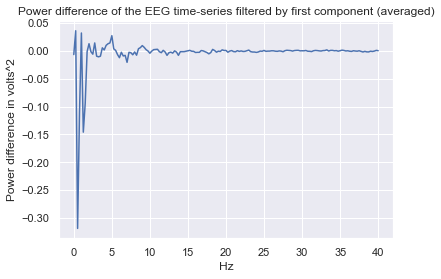

In [29]:

import seaborn as sns
sns.set_theme()
plt.plot(freq(ep1)[1],np.mean(freqs,axis=0).reshape(161,))
plt.title('Power difference of the EEG time-series filtered by first component (averaged)')
plt.xlabel('Hz')
plt.ylabel('Power difference in volts^2')

#np.mean(freqs,axis=0).reshape(161,)

In [200]:
freqs1 = np.reshape(freqs,[10,161])
plt.plot(freq(ep1)[1],(freqs1.T))
plt.title('Power difference of the EEG time-series filtered by first component (all subjects)')
plt.xlabel('Hz')
plt.ylabel('Power difference in volts^2')


Effective window size : 4.000 (s)


Text(0, 0.5, 'Power difference in volts^2')

In [31]:
#import scipy
#scipy.stats.ttest_1samp((np.reshape(np.mean(np.reshape(freqs,[10,161])[:,alpha],axis=0),[57,1])),popmean=0)
def ttest(s):
    alpha = np.where((np.logical_and(freq(ep1)[1]>=s[0], freq(ep1)[1]<=s[1])))
    _,a,_ = mne.stats.permutation_t_test(np.reshape(np.mean(np.reshape(freqs,[10,161])[:,alpha],axis=0),[len(alpha[0]),1]),n_permutations=1000)
    return a
#(np.mean(np.reshape(freqs,[10,161])[:,alpha],axis=0),)


In [121]:
%matplotlib qt
%gui qt

to_not_miss = d[band[4]]
l = ttest(to_not_miss)
plt.xlabel('p-value = {}'.format(l))
    
    #plt.plot(freq(ep1)[1][alpha],np.mean(freqs,axis=0).reshape(161,)[alpha])
alpha = np.where((np.logical_and(freq(ep1)[1]>=to_not_miss[0], freq(ep1)[1]<=to_not_miss[1])))

freqs1 = np.reshape(freqs,[10,161])
freqs2 = (np.reshape(freqs1[:,alpha],[10,len(alpha[0])]))
freq_mean = np.mean(freqs2,axis=0)

plt.boxplot(freq_mean)
    
plt.title('{} band'.format(band[4]))
plt.ylabel('Power difference (volts)^2 ')
plt.tight_layout()

plt.figure()

#plt.savefig('{} band.jpg'.format(band[1]))


Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 255 times (exact test)...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


<Figure size 432x288 with 0 Axes>

In [89]:
d[band[2]]

(15, 29)

In [224]:


a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))
band = ['theta','alpha','beta','gamma','delta']
for i in range(5):
    plt.subplot(a, b, c)
    l = ttest(d[band[i]])
    plt.xlabel('p-value = {}'.format(l))
    
    #plt.plot(freq(ep1)[1][alpha],np.mean(freqs,axis=0).reshape(161,)[alpha])
    alpha = np.where((np.logical_and(freq(ep1)[1]>=d[band[i]][0], freq(ep1)[1]<=d[band[i]][1])))

    freqs1 = np.reshape(freqs,[10,161])
    freqs2 = (np.reshape(freqs1[:,alpha],[10,len(alpha[0])]))
    freq_mean = np.mean(freqs2,axis=0)
    plt.boxplot(freq_mean)
    
    plt.title('{} band'.format(band[i]))
    plt.ylabel('Power difference (volts)^2 ')

    c = c + 1
    
plt.tight_layout()
plt.show()

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 255 times (exact test)...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 999 times...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 999 times...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 999 times...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 255 times (exact test)...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


In [ ]:
%matplotlib qt
%gui qt
def plot_band(kind, band):
    """Plot activity within a frequency band on the subject's brain."""
    #title = "%s\n(%d Hz)" % (freq_bands[band])
    topos[band].plot_topomap(
         scalings=1., cbar_fmt='%0.1f', vmin=0, cmap='inferno')
    brain = stcs_dict[band].plot(
        subject=subject, subjects_dir=subjects_dir, views='cau', hemi='lh',
         colormap='inferno',backend='matplotlib',
        time_viewer=False, show_traces=False,
        clim=dict(kind='percent', lims=(70, 85, 99)), smoothing_steps=10)
    brain.show_view(dict(azimuth=0, elevation=0), roll=0)

fig_theta, brain_theta = plot_band('vv', 'alpha')

In [37]:
def high_minus_low(high,low,band):
    return high[band] - low[band]

## Low ISC

In [38]:

def difference_and_t_test(band):
    alpha_difference_1 = high_minus_low(stc1_high,stc1_low,band)
    alpha_difference_2 = high_minus_low(stc2_high,stc2_low,band)
    alpha_difference_3 = high_minus_low(stc3_high,stc3_low,band)
    alpha_difference_4 = high_minus_low(stc4_high,stc4_low,band)
    alpha_difference_5 = high_minus_low(stc5_high,stc5_low,band)
    alpha_difference_6 = high_minus_low(stc6_high,stc6_low,band)
    alpha_difference_7 = high_minus_low(stc7_high,stc7_low,band)
    alpha_difference_8 = high_minus_low(stc8_high,stc8_low,band)
    alpha_difference_9 = high_minus_low(stc9_high,stc9_low,band)
    alpha_difference_10 = high_minus_low(stc10_high,stc10_low,band)
    averaged_alpha =(alpha_difference_1+alpha_difference_2+alpha_difference_3+alpha_difference_4+alpha_difference_5\
          +alpha_difference_6+alpha_difference_7+alpha_difference_8+alpha_difference_9+alpha_difference_10)/10
    a,b,c = mne.stats.permutation_t_test(averaged_alpha.data,n_permutations=1000)
    alpha_stacked = (np.hstack((alpha_difference_1.data,alpha_difference_2.data,\
                   alpha_difference_3.data,alpha_difference_4.data,\
                   alpha_difference_5.data,alpha_difference_6.data,\
                   alpha_difference_7.data,alpha_difference_8.data,\
                   alpha_difference_9.data,alpha_difference_10.data)))
    return averaged_alpha,alpha_stacked,b

In [82]:
averaged,to_test,b = difference_and_t_test('gamma')
#plt.hist(averaged.data)

Permuting 999 times...


In [83]:
indices_for_slicing_beyond_percentiles = np.where( np.logical_or( (averaged.data <np.percentile(averaged.data,10)), (averaged.data>np.percentile(averaged.data,90))))

averaged.data[list(set(list(range(20484)))-set(indices_for_slicing_beyond_percentiles[0]))] =0

In [271]:
%matplotlib qt
%gui qt
def plot(views,hemi,string):
    
    brain = averaged.plot(subjects_dir=subjects_dir, time_unit='s',hemi=hemi,background='grey',views=views
                          ,backend='matplotlib',colormap='seismic',clim=dict(kind='value', lims=[-averaged.data.max(), np.median(averaged.data), averaged.data.max()]))
    plt.title('Condition -"High- Low"')
    #brain.savefig('S4B2/results_high_minus_low')
    return None

In [272]:
plot('lat','lh','Lateral Left')
plot('lat','rh','Lateral Right')
plot('cau','lh','Caudal Left')
plot('cau','rh','Caudal Right')
plot('med','lh','Medial Left')
plot('med','rh','Medial Right')


Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surfac

In [122]:

l = difference_and_t_test(band[4])
plt.xlabel('p-value = {}'.format(l[2]))


plt.boxplot(l[0].data)

plt.ylabel('Power difference in micro volts')
plt.title('{} band (source level)'.format(band[4]))
plt.figure()
plt.tight_layout()
plt.show(block=False)
#plt.savefig('{} band(source level).jpg'.format(band[0]))
#plt.close()

Permuting 999 times...


In [111]:
d =dict(delta=(2, 4), theta=(5, 7), alpha=(8, 13), beta=(15, 29), gamma=(30, 40))

l = ttest(d[band[1]])
plt.xlabel('p-value = {}'.format(l))
    #plt.plot(freq(ep1)[1][alpha],np.mean(freqs,axis=0).reshape(161,)[alpha])
    
alpha = np.where((np.logical_and(freq(ep1)[1]>=d[band[1]][0], freq(ep1)[1]<=d[band[1]][1])))

freqs1 = np.reshape(freqs,[10,161])
freqs2 = (np.reshape(freqs1[:,alpha],[10,len(alpha[0])]))
freq_mean = np.mean(freqs2,axis=0)
plt.boxplot(freq_mean)
plt.tight_layout()
plt.title('{} band'.format(band[1]))
plt.ylabel('Power difference (volts)^2 ')

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Permuting 999 times...
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


Text(21.299999999999997, 0.5, 'Power difference (volts)^2 ')

In [34]:
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))
band = ['theta','alpha','beta','gamma','delta']
for i in range(5):
    plt.subplot(a, b, c)
    l = difference_and_t_test(band[i])
    plt.xlabel('p-value = {}'.format(l[2]))
    print(l[0])
    plt.boxplot(l[0].data)
    plt.title('{} band'.format(band[i]))
    plt.ylabel('Power difference in micro volts')

    c = c + 1
    
plt.tight_layout()
plt.show()

NameError: name 'difference_and_t_test' is not defined

In [61]:
#np.shape(epochs_averaged)
#epochs_ready_ISC_ts_low = np.reshape(epochs_averaged_ISC_ts_low,[1,91,2060])
b

Permuting 999 times...


array([0.001])

In [48]:
events = np.zeros([2,3],dtype=int)
#def ISCed_inversion(subject,events):
 #   e = epochs(subject,events)
events[0][0] = 1
events[0][2] = 83


info_low = mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg')

raw_low = mne.io.RawArray(epochs_averaged_ISC_ts_low,info)
ep_low = mne.EpochsArray(epochs_ready_ISC_ts_low,info_low)




Creating RawArray with float64 data, n_channels=91, n_times=2060
    Range : 0 ... 2059 =      0.000 ...     4.118 secs
Ready.
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [49]:
#mne.make_fixed_length_events(raw,start=0,duration = 0.5)
raw_low.set_montage('GSN-HydroCel-129')

TypeError: expected str, bytes or os.PathLike object, not NoneType

<RawArray | 91 x 2060 (4.1 s), ~1.6 MB, data loaded>

In [55]:
stc_psd_low,sensor_psd_low = comp_source_psd(raw_low)

Using up to 20 segments
Number of samples used : 2000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 2.8 (2.2e-16 eps * 91 dim * 1.4e+14  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computin

<ipython-input-52-5a15ac21a8ce>:6: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-52-5a15ac21a8ce>:6: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 4.96348
    scaling factor to adjust the trace = 6.7643e+07 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 10 (5e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 91
Using hann windowing on at most

  0%|          |  : 0/2 [00:00<?,       ?it/s]

In [68]:

freq_bands_2 = dict(
        delta=(2, 4), theta=(5, 7), alpha=(8, 13), beta=(15, 29), gamma=(30, 45))
topos_2 = dict(vv=dict(), opm=dict())
stcs_dict_2 = dict(vv=dict(), opm=dict())
    
    
topo_norm_2 = sensor_psd_low.data.sum(axis=1, keepdims=True)
stc_norm_2 = stc_psd_low.sum() 

for band, limits in freq_bands_2.items():
        data = sensor_psd_low.copy().crop(*limits).data.sum(axis=1, keepdims=True)
        topos_2[band] = mne.EvokedArray(
            100 * data / topo_norm_2, sensor_psd_low.info)
        stcs_dict_2[band] = \
            100 * stc_psd_low.copy().crop(*limits).sum() / stc_norm_2.data

<ipython-input-68-b823aa4c9406>:11: RuntimeWarning: tmax is not in Evoked time interval. tmax is set to evoked.tmax (39.7949 sec)
  data = sensor_psd_low.copy().crop(*limits).data.sum(axis=1, keepdims=True)


In [77]:
%matplotlib qt
%gui qt
def plot_band2(kind, band):
    """Plot activity within a frequency band on the subject's brain."""
    #title = "%s\n(%d Hz)" % (freq_bands[band])
    topos_2[band].plot_topomap(
         scalings=1., cbar_fmt='%0.1f',vmin=4.434287102645273e-10, cmap='inferno')
    
    brain = stcs_dict_2[band].plot(
        subject=subject, subjects_dir=subjects_dir, views='cau', hemi='lh',
         colormap='inferno',backend='matplotlib',
        time_viewer=False, show_traces=False,
        clim=dict(kind='percent', lims=(70, 85, 99)), smoothing_steps=10)
    brain.show_view(dict(azimuth=0, elevation=0), roll=0)

fig_theta, brain_theta = plot_band2('vv', 'alpha')

Using control points [22.27427641 25.61981469 34.17295972]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


AttributeError: 'Figure' object has no attribute 'show_view'

In [29]:
mins =list()
maxs = list()
for band, limits in freq_bands.items():
        
        mins.append(np.min(topos[band].data))
        maxs.append(np.max(topos[band].data))
print(np.where(mins==np.min(mins)))
print(np.where(maxs==np.max(maxs)))
#topos

(array([4]),)
(array([0]),)


# Independent Source Inversion

In [12]:
indexes = np.hstack([np.arange(159*500-50,159*500+50)])#,np.arange(67*500,72*500),np.arange(77*500,84*500),np.arange(130*500,136*500),np.arange(155*500,165*500)])
indexes_low = np.hstack([np.arange(100*500-50,100*500+50)])

In [13]:

def ISCed_inversion(indexed_subject_data):
    #e = epochs(subject,events)
    
    ep = mne.EpochsArray(indexed_subject_data,mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg'))
    raw = mne.io.RawArray(ep.get_data().reshape(91,100),sub1_raw.info)


    cov_ =mne.compute_covariance(ep)


    
    inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    method = "eLORETA"
    snr = 3.
    lambda2 = 1. / snr ** 2


    stc = apply_inverse_epochs(ep, inverse_operator, lambda2,
                             method=method, pick_ori=None, verbose=True)
    
    
    return stc


In [22]:
np.shape(epochs1_ISC_ts.get_data()[:,:,indexes])

(1, 91, 2060)

In [92]:
#isc_results['condition1']['A'][0]
#sub1_trial = isc_results['condition1']['A'][0] @ sub1_raw.get_data()
import tqdm
#sub1_trial = np.zeros([91,85001])
#a = [sub1_trial[:,i] (sub1_raw.get_data()[:,i]*isc_results['condition1']['A'][0]) for i in tqdm.tqdm(range(86040))]
 #sub1_trial[:,i] = (sub1_raw.get_data()[:,i]*isc_results['condition1']['A'][0])   

def element_wise_multi(epochs):
    subjects = isc_results['condition1']['A'][0] @ epochs
    return subjects

(element_wise_multi(epochs5_ISC_ts.get_data()[:,:,indexes]))

#np.shape(isc_results['condition1']['A'][0],sub1_raw.get_data())

array([[-0.27480874,  0.8037702 ,  1.50161777, ..., -1.98247456,
        -1.77634126, -2.79833024]])

In [17]:
def epochs_filter(epochs1_ISC_ts,epochs2_ISC_ts,epochs3_ISC_ts,epochs4_ISC_ts,epochs5_ISC_ts,epochs6_ISC_ts,\
                 epochs7_ISC_ts,epochs8_ISC_ts,epochs9_ISC_ts,epochs10_ISC_ts,indexes):
    epochs1_ISC_ts_filtered = element_wise_multi(epochs1_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs2_ISC_ts_filtered = element_wise_multi(epochs2_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs3_ISC_ts_filtered = element_wise_multi(epochs3_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs4_ISC_ts_filtered = element_wise_multi(epochs4_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs5_ISC_ts_filtered = element_wise_multi(epochs5_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs6_ISC_ts_filtered = element_wise_multi(epochs6_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs7_ISC_ts_filtered = element_wise_multi(epochs7_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs8_ISC_ts_filtered = element_wise_multi(epochs8_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs9_ISC_ts_filtered = element_wise_multi(epochs9_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    epochs10_ISC_ts_filtered = element_wise_multi(epochs10_ISC_ts.get_data()[:,:,indexes].reshape([91,100]))
    
    return epochs1_ISC_ts_filtered,epochs2_ISC_ts_filtered,\
            epochs3_ISC_ts_filtered,epochs4_ISC_ts_filtered,\
            epochs5_ISC_ts_filtered,epochs6_ISC_ts_filtered,\
            epochs7_ISC_ts_filtered,epochs8_ISC_ts_filtered,\
            epochs9_ISC_ts_filtered,epochs10_ISC_ts_filtered

In [206]:
fwd_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)

def inversion(epochs1_ISC_ts_filtered,epochs2_ISC_ts_filtered,epochs3_ISC_ts_filtered,epochs4_ISC_ts_filtered,\
             epochs5_ISC_ts_filtered,epochs6_ISC_ts_filtered,epochs7_ISC_ts_filtered,epochs8_ISC_ts_filtered,\
             epochs9_ISC_ts_filtered,epochs10_ISC_ts_filtered):
    
    sub1_ISC_trial = ISCed_inversion(epochs1_ISC_ts_filtered.reshape([1,91,100]))
    sub2_ISC_trial = ISCed_inversion(epochs2_ISC_ts_filtered.reshape([1,91,100]))
    sub3_ISC_trial = ISCed_inversion(epochs3_ISC_ts_filtered.reshape([1,91,100]))
    sub4_ISC_trial = ISCed_inversion(epochs4_ISC_ts_filtered.reshape([1,91,100]))
    sub5_ISC_trial = ISCed_inversion(epochs5_ISC_ts_filtered.reshape([1,91,100]))
    sub6_ISC_trial = ISCed_inversion(epochs6_ISC_ts_filtered.reshape([1,91,100]))
    sub7_ISC_trial = ISCed_inversion(epochs7_ISC_ts_filtered.reshape([1,91,100]))
    sub8_ISC_trial = ISCed_inversion(epochs8_ISC_ts_filtered.reshape([1,91,100]))
    sub9_ISC_trial = ISCed_inversion(epochs9_ISC_ts_filtered.reshape([1,91,100]))
    sub10_ISC_trial = ISCed_inversion(epochs10_ISC_ts_filtered.reshape([1,91,100]))
    averaged_stc = (sub1_ISC_trial[0]+sub2_ISC_trial[0]+sub3_ISC_trial[0]+sub4_ISC_trial[0]+sub5_ISC_trial[0]+sub6_ISC_trial[0]+sub7_ISC_trial[0]+sub8_ISC_trial[0]+sub9_ISC_trial[0]+sub10_ISC_trial[0])/10
    
    return averaged_stc
            

Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  91 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BE

In [207]:
epochs1_ISC_ts_filtered,epochs2_ISC_ts_filtered,\
            epochs3_ISC_ts_filtered,epochs4_ISC_ts_filtered,\
            epochs5_ISC_ts_filtered,epochs6_ISC_ts_filtered,\
            epochs7_ISC_ts_filtered,epochs8_ISC_ts_filtered,\
            epochs9_ISC_ts_filtered,epochs10_ISC_ts_filtered = epochs_filter(epochs1_ISC_ts,epochs2_ISC_ts,epochs3_ISC_ts,epochs4_ISC_ts,epochs5_ISC_ts,epochs6_ISC_ts,\
                 epochs7_ISC_ts,epochs8_ISC_ts,epochs9_ISC_ts,epochs10_ISC_ts,indexes)


epochs1_ISC_ts_filtered_low,epochs2_ISC_ts_filtered_low,\
            epochs3_ISC_ts_filtered_low,epochs4_ISC_ts_filtered_low,\
            epochs5_ISC_ts_filtered_low,epochs6_ISC_ts_filtered_low,\
            epochs7_ISC_ts_filtered_low,epochs8_ISC_ts_filtered_low,\
            epochs9_ISC_ts_filtered_low,epochs10_ISC_ts_filtered_low = epochs_filter(epochs1_ISC_ts,epochs2_ISC_ts,epochs3_ISC_ts,epochs4_ISC_ts,epochs5_ISC_ts,epochs6_ISC_ts,\
                 epochs7_ISC_ts,epochs8_ISC_ts,epochs9_ISC_ts,epochs10_ISC_ts,indexes_low)

In [208]:
#fwd_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)
avg_ISC_trial = inversion(epochs1_ISC_ts_filtered,epochs2_ISC_ts_filtered,epochs3_ISC_ts_filtered,epochs4_ISC_ts_filtered,\
             epochs5_ISC_ts_filtered,epochs6_ISC_ts_filtered,epochs7_ISC_ts_filtered,epochs8_ISC_ts_filtered,\
             epochs9_ISC_ts_filtered,epochs10_ISC_ts_filtered)


avg_trial_low = inversion(epochs1_ISC_ts_filtered_low,epochs2_ISC_ts_filtered_low,\
            epochs3_ISC_ts_filtered_low,epochs4_ISC_ts_filtered_low,\
            epochs5_ISC_ts_filtered_low,epochs6_ISC_ts_filtered_low,\
            epochs7_ISC_ts_filtered_low,epochs8_ISC_ts_filtered_low,\
            epochs9_ISC_ts_filtered_low,epochs10_ISC_ts_filtered_low)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.198 secs
Ready.
Computing rank from data with rank=None
    Using tolerance 4.8e-07 (2.2e-16 eps * 91 dim * 2.4e+07  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
Reducing data rank from 91 -> 91
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 100
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 91 dim * 5.6e+10  max singular value)
    Estimated rank (eeg): 73
    EEG: rank 73 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.27018
    scaling factor to adjust the trace = 1.74534e+21 (nchan = 91 nzero = 18)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 73 (18 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (7.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 91 dim * 5.1e+10  max singular value)
    Estimated rank (eeg): 79
    EEG: rank 79 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.78169
    scaling factor to adjust the trace = 1.08236e+21 (nchan = 91 nzero = 12)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 79 (12 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (4.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00062 (2.2e-16 eps * 91 dim * 3.1e+10  max singular value)
    Estimated rank (eeg): 79
    EEG: rank 79 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.86398
    scaling factor to adjust the trace = 2.05809e+21 (nchan = 91 nzero = 12)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 79 (12 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.4e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0026 (2.2e-16 eps * 91 dim * 1.3e+11  max singular value)
    Estimated rank (eeg): 79
    EEG: rank 79 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.13231
    scaling factor to adjust the trace = 7.02445e+20 (nchan = 91 nzero = 12)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 79 (12 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.6e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0039 (2.2e-16 eps * 91 dim * 1.9e+11  max singular value)
    Estimated rank (eeg): 78
    EEG: rank 78 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.75415
    scaling factor to adjust the trace = 2.84957e+20 (nchan = 91 nzero = 13)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 78 (13 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (9.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0008 (2.2e-16 eps * 91 dim * 4e+10  max singular value)
    Estimated rank (eeg): 80
    EEG: rank 80 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.73928
    scaling factor to adjust the trace = 1.96291e+21 (nchan = 91 nzero = 11)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 80 (11 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (8.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0005 (2.2e-16 eps * 91 dim * 2.5e+10  max singular value)
    Estimated rank (eeg): 77
    EEG: rank 77 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.6269
    scaling factor to adjust the trace = 4.35799e+21 (nchan = 91 nzero = 14)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 77 (14 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.1e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cre

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00047 (2.2e-16 eps * 91 dim * 2.3e+10  max singular value)
    Estimated rank (eeg): 79
    EEG: rank 79 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.22388
    scaling factor to adjust the trace = 4.7414e+21 (nchan = 91 nzero = 12)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 79 (12 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (8.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cre

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00073 (2.2e-16 eps * 91 dim * 3.6e+10  max singular value)
    Estimated rank (eeg): 78
    EEG: rank 78 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.89132
    scaling factor to adjust the trace = 2.03932e+21 (nchan = 91 nzero = 13)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 78 (13 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.9e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 91 dim * 6.3e+10  max singular value)
    Estimated rank (eeg): 79
    EEG: rank 79 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.77704
    scaling factor to adjust the trace = 9.62411e+20 (nchan = 91 nzero = 12)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 79 (12 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00035 (2.2e-16 eps * 91 dim * 1.8e+10  max singular value)
    Estimated rank (eeg): 77
    EEG: rank 77 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.80324
    scaling factor to adjust the trace = 4.72592e+21 (nchan = 91 nzero = 14)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 77 (14 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (4.5e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0025 (2.2e-16 eps * 91 dim * 1.3e+11  max singular value)
    Estimated rank (eeg): 83
    EEG: rank 83 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 5.37294
    scaling factor to adjust the trace = 4.32466e+20 (nchan = 91 nzero = 8)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 83 (8 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (5.6e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Crea

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.00063 (2.2e-16 eps * 91 dim * 3.1e+10  max singular value)
    Estimated rank (eeg): 78
    EEG: rank 78 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.93609
    scaling factor to adjust the trace = 3.2839e+21 (nchan = 91 nzero = 13)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 78 (13 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cre

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 91 dim * 5e+10  max singular value)
    Estimated rank (eeg): 81
    EEG: rank 81 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.04506
    scaling factor to adjust the trace = 1.93633e+21 (nchan = 91 nzero = 10)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 81 (10 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (4.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0078 (2.2e-16 eps * 91 dim * 3.9e+11  max singular value)
    Estimated rank (eeg): 78
    EEG: rank 78 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 7.00273
    scaling factor to adjust the trace = 2.33291e+20 (nchan = 91 nzero = 13)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 78 (13 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (2.5e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cr

<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov_ =mne.compute_covariance(ep)
<ipython-input-13-345bb3e1c0ab>:8: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  cov_ =mne.compute_covariance(ep)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.0075 (2.2e-16 eps * 91 dim * 3.7e+11  max singular value)
    Estimated rank (eeg): 78
    EEG: rank 78 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)
<ipython-input-13-345bb3e1c0ab>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov_)


    largest singular value = 6.29055
    scaling factor to adjust the trace = 2.57289e+20 (nchan = 91 nzero = 13)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 78 (13 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...


KeyboardInterrupt: 

<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 198.0 (ms), tstep : 2.0 (ms), data shape : (20484, 100), ~15.8 MB>

In [64]:


vertno_max, time_max = averaged_stc.get_peak()
%matplotlib qt
%gui qt 

fig, ax = plt.subplots()
ax.plot(1e3 * averaged_stc.times, averaged_stc.data.T)
method = "eLORETA"
ax.set(xlabel='time (ms)', ylabel='%s value' % method)




views = 'lat'
brain = averaged_stc.plot(subjects_dir=subjects_dir, initial_time=time_max, time_unit='s',hemi='lh',background='grey',views=views
                          ,backend='matplotlib', colormap='inferno'
                          ,title='eLORETA for the peak of the peak ')
plt.title('eLORETA for the peak of the peak (Lateral)' )
#surfer_kwargs = dict(
 #   hemi='both', subjects_dir=subjects_dir,
  #  clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
   # initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
#brain = stc.plot(**surfer_kwargs)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',scale_factor=0.6, alpha=0.5)
#brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='red',scale_factor=0.6, alpha=0.5)

#brain.title(0.1, 0.9, 'eLORETA for the peak of the peak (%s)' % views ,font_size=14)



Using control points [4.47084678e-12 4.67544432e-12 6.14530220e-12]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


Text(0.5, 1.0, 'eLORETA for the peak of the peak (Lateral)')

In [59]:
def plot(views,hemi,string):
    
    brain = averaged_stc.plot(subjects_dir=subjects_dir, initial_time=time_max, time_unit='s',hemi=hemi,background='grey',views=views
                          ,backend='matplotlib', colormap='inferno'
                          ,title='eLORETA for the peak of the peak ')
    plt.title('eLORETA (Filtered by 1st comp) for the peak of the peak (%s)' %string)
    brain.savefig('S4B2/Results(Filtered by first component)/%s.jpg' %string)
    return None

In [112]:
plot('lat','lh','Lateral Left')
plot('lat','rh','Lateral Right')


plot('med','lh','Medial Left')
plot('med','rh','Medial Right')

plot('ros','lh','Rostral Left')
plot('ros','rh','Rostral Right')

plot('cau','lh','Caudal Left')
plot('cau','rh','Caudal Right')

plot('dor','lh','Dorsal Left')
plot('dor','rh','Dorsal Right')


Using control points [4.47084678e-12 4.67544432e-12 6.14530220e-12]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
Using control points [4.47084678e-12 4.67544432e-12 6.14530220e-12]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-sample-data/subjects/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
Using control points [4.47084678e-12 4.67544432e-12 6.14530220e-12]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /homes/v20subra/mne_data/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.
U

In [26]:
#def psd_ISC(indexed_subject_data):    
freq_bands = dict(
        delta=(2, 4), theta=(5, 7), alpha=(8, 13), beta=(15, 29), gamma=(30, 45))
topos = dict(vv=dict(), opm=dict())
stcs_dict = dict(vv=dict(), opm=dict())

ep = mne.EvokedArray(e1.get_data()[:,:,indexes].reshape(91,100),mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg'))
raw = mne.io.RawArray(ep.data.reshape(91,100),sub1_raw.info)

    
noise_cov = mne.compute_raw_covariance(raw)
inverse_operator = mne.minimum_norm.make_inverse_operator(
        raw.info, forward=fwd_model, noise_cov=noise_cov, verbose=True)
    

method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2

    
stc_psd, sensor_psd = mne.minimum_norm.compute_source_psd(
        raw, inverse_operator, lambda2=lambda2,method=method,fmax=40,
        dB=False, return_sensor=True, verbose=True)


Creating RawArray with float64 data, n_channels=91, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.198 secs
Ready.
Using up to 1 segment
Number of samples used : 100
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking


<ipython-input-26-d0d8705cecc8>:11: RuntimeWarning: Too few samples (required : 460 got : 100), covariance estimate may be unreliable
  noise_cov = mne.compute_raw_covariance(raw)


Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 91 dim * 5.8e+12  max singular value)
    Estimated rank (eeg): 89
    EEG: rank 89 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-26-d0d8705cecc8>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
<ipython-input-26-d0d8705cecc8>:12: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.36019
    scaling factor to adjust the trace = 6.21068e+17 (nchan = 91 nzero = 2)


ValueError: No events produced, check the values of start, stop, and duration

In [28]:
#psd_ISC(e1.get_data()[:,:,indexes])
ep.data.shape

(91, 100)

# Statistics at source

In [30]:

adjacency = mne.spatial_src_adjacency(inverse_operator['src'])


-- number of adjacent vertices : 20484


In [31]:
n_vertices, n_times =20484, 1



In [32]:
adjacency

<20484x20484 sparse matrix of type '<class 'numpy.int64'>'
	with 143364 stored elements in COOrdinate format>

In [33]:
vertices = [s['vertno'] for s in inverse_operator['src']]
vertices

[array([    0,     1,     2, ..., 10239, 10240, 10241]),
 array([    0,     1,     2, ..., 10239, 10240, 10241])]

In [26]:
spatiotemp = np.append(np.reshape(sub1_ISC_trial[0].data,[1,100,20484]),np.reshape(sub2_ISC_trial[0].data,[1,100,20484]),axis=0)


spatiotemp = np.append(spatiotemp,np.reshape(sub3_ISC_trial[0].data,[1,100,20484]),axis=0)

spatiotemp = np.append(spatiotemp,np.reshape(sub4_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub5_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub6_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub7_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub8_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub9_ISC_trial[0].data,[1,100,20484]),axis=0)
spatiotemp = np.append(spatiotemp,np.reshape(sub10_ISC_trial[0].data,[1,100,20484]),axis=0)

In [27]:
spatiotemp2 = np.append(np.reshape(sub1_ISC_trial_low[0].data,[1,100,20484]),np.reshape(sub2_ISC_trial_low[0].data,[1,100,20484]),axis=0)


spatiotemp2 = np.append(spatiotemp2,np.reshape(sub3_ISC_trial_low[0].data,[1,100,20484]),axis=0)

spatiotemp2 = np.append(spatiotemp2,np.reshape(sub4_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub5_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub6_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub7_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub8_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub9_ISC_trial_low[0].data,[1,100,20484]),axis=0)
spatiotemp2 = np.append(spatiotemp2,np.reshape(sub10_ISC_trial_low[0].data,[1,100,20484]),axis=0)

In [57]:
a =mne.time_frequency.psd_welch(ep1,fmax=40)

Effective window size : 0.512 (s)


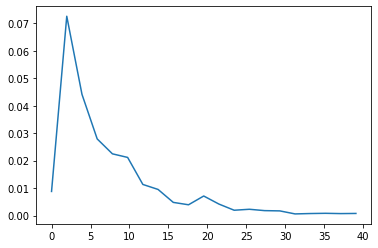

In [59]:
plt.plot(a[1],a[0].reshape(21,))

In [46]:
from scipy import stats as stats
from mne.stats import (spatio_temporal_cluster_1samp_test,summarize_clusters_stc)

n_subjects = 10
p_threshold = 0.001
t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)
print('Clustering.')
T_obs, clusters, cluster_p_values, H0 = clu = \
    spatio_temporal_cluster_1samp_test((np.reshape(to_test.data,[10,1,20484])), adjacency=adjacency, n_jobs=1,
                                       threshold=t_threshold, buffer_size=None,n_permutations=1000,
                                       verbose=True)



good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


Clustering.
stat_fun(H1): min=-1.236862 max=2.763210
Running initial clustering
Found 0 clusters


<ipython-input-46-e5080db02285>:9: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  spatio_temporal_cluster_1samp_test((np.reshape(to_test.data,[10,1,20484])), adjacency=adjacency, n_jobs=1,


In [83]:
cluster_p_values

array([], dtype=float64)

In [197]:
#tstep = averaged.tstep *1000

stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,p_thresh=0.001,
                                             vertices=vertices,
                                             subject='fsaverage')

RuntimeError: No significant clusters available. Please adjust your threshold or check your statistical analysis.

In [85]:
import epochs_slicing 
from imp import reload 

reload(epochs_slicing)

<module 'epochs_slicing' from '/homes/v20subra/S4B2/epochs_slicing.py'>

In [90]:
epochs_slicing.epochs(sub1_raw,sub1_events,[83,103,9999],0,170,500,'83')

Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped


Number of events,1
Events,83: 1
Time range,0.000 – 170.000 sec
Baseline,0.000 – 170.000 sec


In [14]:
import nilearn.surface
nilearn.surface.load_surf_data('fsaverage5.gii')

array([7.464764 , 6.3432045, 4.883819 , ..., 7.7171664, 6.926384 ,
       6.9226246], dtype=float32)

In [8]:
import numpy as np
np.shape(labels)

(181,)

In [15]:
aud_label = [label for label in labels if label.name == 'R_10d_ROI-rh'][0]


/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


(30, 30)
30 nodes, 60 edges


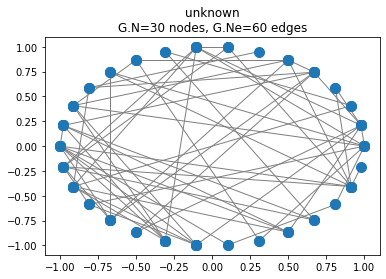

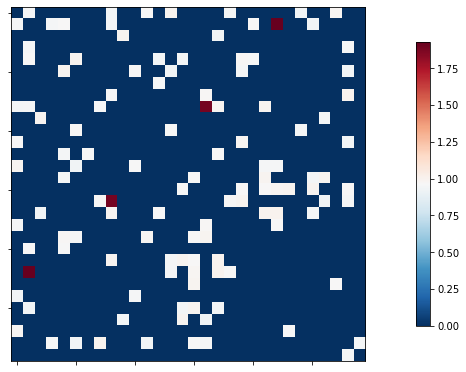

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters
from pygsp import plotting as gsp_plt
from nilearn import image, plotting, datasets

rs = np.random.RandomState(42)  # Reproducible results.
W = rs.uniform(size=(30, 30))  # Full graph.
#print(rs.__doc__)
print (W.shape)
W[W < 0.93] = 0  # Sparse graph.
W = W + W.T  # Symmetric graph.
np.fill_diagonal(W, 0)  # No self-loops.
G_simple = graphs.Graph(W)
print('{} nodes, {} edges'.format(G_simple.N, G_simple.Ne))


G_simple.set_coordinates('ring2D')
G_simple.plot()
plotting.plot_matrix(W, colorbar=True)

#print(G.L)

In [20]:
from pathlib import Path
from scipy import io as sio
from pygsp import graphs

path_Glasser='Glasser_masker.nii.gz'
res_path=''

# Load structural connectivity matrix
connectivity = sio.loadmat('S4B2/GSP/SC_avg56.mat')['SC_avg56']
connectivity.shape
coordinates = sio.loadmat('S4B2/GSP/Glasser360_2mm_codebook.mat')['codeBook'] # coordinates in brain space


G_Comb = graphs.Graph(connectivity,gtype='HCP subject',lap_type='combinatorial',coords=coordinates)# combinatorial laplacian
G=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
G_RandW=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
print(G.is_connected())


G.set_coordinates('spring')
#G.plot()   #edges > 10^4 not shown
D=np.array(G.dw)
D.shape


True


(360,)

In [21]:
import numpy as np
with np.load(f"S4B2/GSP/hcp/atlas.npz") as dobj:
    atlas = dict(**dobj)

In [22]:
l =list()
for i in list(set(atlas['labels_L']))[:-1]:
    l.append(np.mean(stc_isc[0].data[10242:][np.where(i== atlas['labels_L'])]))

for i in list(set(atlas['labels_R']))[:-1]:
    l.append(np.mean(stc_isc[0].data[:10242][np.where(i== atlas['labels_R'])]))
    

In [26]:
G.compute_fourier_basis()


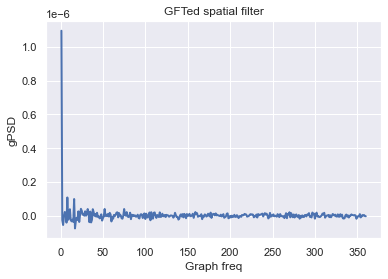

In [33]:
from data import sns_plot


sns_plot.plot(range(len(G.gft(np.array(l)))),G.gft(np.array(l)),xlabel='Graph freq',ylabel='gPSD',title='GFTed spatial filter')

In [32]:
a=0
for i in range(1,len(labels)):
    a+= len(labels[i].values)
a

NameError: name 'labels' is not defined

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


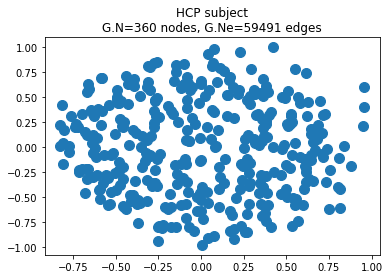

In [33]:
G_Comb.set_coordinates()
G_Comb.plot()

ValueError: File not found: 'Glasser_masker.nii.gz'

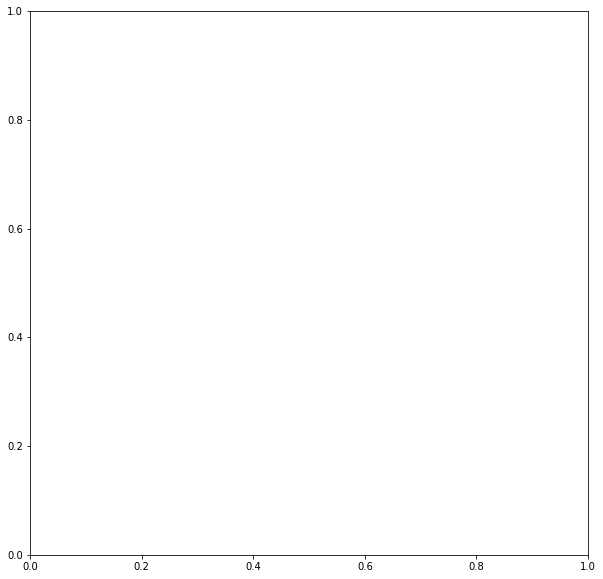

In [38]:
from nilearn.regions import signals_to_img_labels  
# load nilearn label masker for inverse transform
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
from nilearn import datasets
from os.path import join as opj


path_Glasser = 'S4B2/GSP/Glasser_masker.nii.gz'


mnitemp = fetch_icbm152_2009()
mask_mni=image.load_img(mnitemp['mask'])
glasser_atlas=image.load_img(path_Glasser)


#print(NiftiMasker.__doc__)


fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))

signal=[]
U0_brain=[]
signal=np.expand_dims(np.array(G.gft(np.array(l))), axis=0) # add dimension 1 to signal array
U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])
plotting.plot_glass_brain(U0_brain,title='GFTed spatial filter',colorbar=True,plot_abs=False,cmap='spring',display_mode='xz',figure=fig,axes=ax)


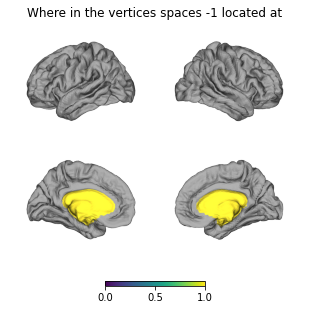

In [90]:
from data import surface_plot
from imp import reload 
reload(surface_plot)

v = np.zeros([20484,])
v[:10242][np.where(atlas['labels_L']==-1)] =1
v[10242:][np.where(atlas['labels_R']==-1)] =1

surface_plot.plot(v,'Where in the vertices spaces -1 located at','viridis',None, c_range = [0,1])

In [79]:
np.sum(v)

1742.0